<a href="https://colab.research.google.com/github/Bagavathiraj655/Bagavathi-/blob/main/eye_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from IPython import get_ipython
from IPython.display import display

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping # Import EarlyStopping here
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [11]:
!pip install scikeras


In [13]:
from google.colab import drive
from PIL import Image

In [14]:
# Step 2: Set Dataset Path
dataset_path = "/content/drive/MyDrive/Dataset"
print("Dataset folders:", os.listdir(dataset_path))

Dataset folders: ['cataract.img', 'glaucoma.img', 'normal.img']


In [15]:
def get_dataset_info(dataset_path):
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    data_info = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        num_images = sum(1 for f in os.scandir(category_path) if f.is_file())  # Count actual image files
        data_info.append({'Category': category, 'Number of Images': num_images})

    df = pd.DataFrame(data_info)  # Convert list of dicts into DataFrame correctly
    print("\nDataset Information:")
    print(df.to_string(index=False))  # Print DataFrame properly formatted
    return df

In [16]:
get_dataset_info(dataset_path)


Dataset Information:
    Category  Number of Images
cataract.img              1038
glaucoma.img              1007
  normal.img              1074


,Category,Number of Images
0,cataract.img,1038
1,glaucoma.img,1007
2,normal.img,1074


In [17]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [18]:
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_gen.flow_from_directory(dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = data_gen.flow_from_directory(dataset_path, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')


Found 2497 images belonging to 3 classes.
Found 622 images belonging to 3 classes.


In [19]:
def create_model(optimizer='adam'):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze layers to prevent retraining

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def show_dataset_images(dataset_path, num_images=10):
    categories = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(categories), num_images, figsize=(num_images * 3, len(categories) * 3))

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_images]

        for j, image_name in enumerate(images):
            img_path = os.path.join(category_path, image_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

show_dataset_images(dataset_path)

In [ ]:
model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping, lr_scheduler])


Epoch 1/5
10/79 ━━━━━━━━━━━━━━━━━━━━ 14:13 12s/step - accuracy: 0.4026 - loss: 5.3991

In [34]:
# Display Final Accuracy (Without Decimals)
final_train_acc = int(history.history['accuracy'][-1] * 100)
final_val_acc = int(history.history['val_accuracy'][-1] * 100)

print(f"Final Training Accuracy: {final_train_acc}%")
print(f"Final Validation Accuracy: {final_val_acc}%")


NameError: name 'history' is not defined

In [ ]:
model.save("/content/drive/MyDrive/eye_disease_model.h5")

In [ ]:
def predict_image(image_path):
    if not os.path.exists(image_path):
        return "Image path not found."
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    class_indices = train_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[np.argmax(prediction)]
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


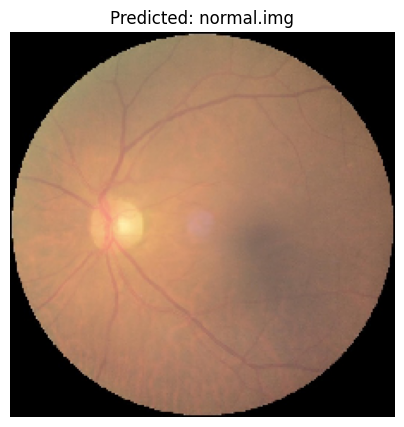

Predicted Class: normal.img


In [33]:
image_path = "/content/drive/MyDrive/Dataset/cataract.img/1102_left.jpg"
result = predict_image(image_path)
print("Predicted Class:", result)

In [ ]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=dataset_info, x='Category', y='Number of Images', palette='viridis')
plt.title("Dataset Distribution")
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

In [ ]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')


In [ ]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

In [ ]:
plt.show()
